In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

### Data preprocessing

In [91]:
# Read the old data from CSV files
df1 = pd.read_csv('data/Jumping_Jack_x10/TotalAcceleration.csv')
df2 = pd.read_csv('data/Lunges_x10/TotalAcceleration.csv')
df3 = pd.read_csv('data/Squat_x10/TotalAcceleration.csv')
# Read the new data from CSV files
df4 = pd.read_csv('data/JJx10-2023-11-19_19-24-30/TotalAcceleration.csv')
df5 = pd.read_csv('data/Lux10-2023-11-19_19-33-46/TotalAcceleration.csv')
df6 = pd.read_csv('data/Sqx10-2023-11-19_19-26-29/TotalAcceleration.csv')

# Remove noisy data at the beginning and end of the datasets
df2 = df2[200:-100].reset_index(drop=True)
df3 = df3[200:-100].reset_index(drop=True)
df5 = df5[350:-100].reset_index(drop=True)

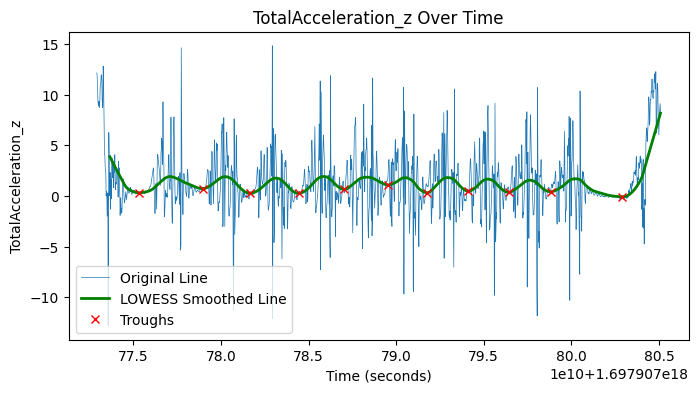

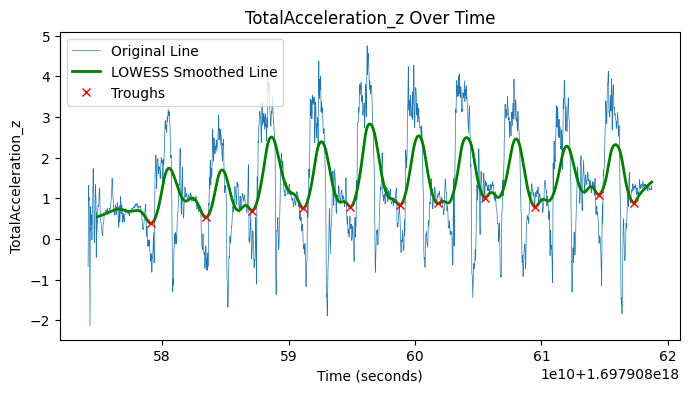

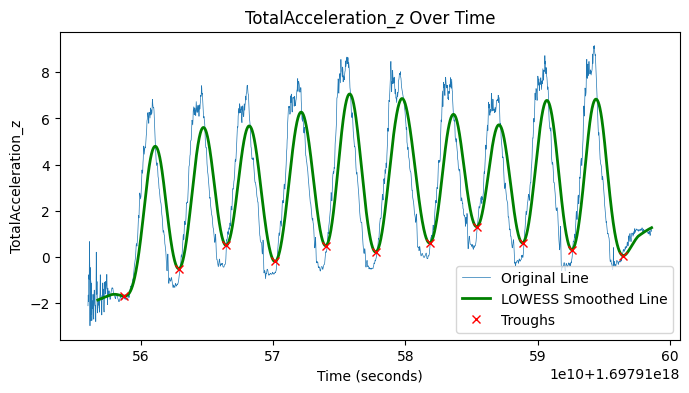

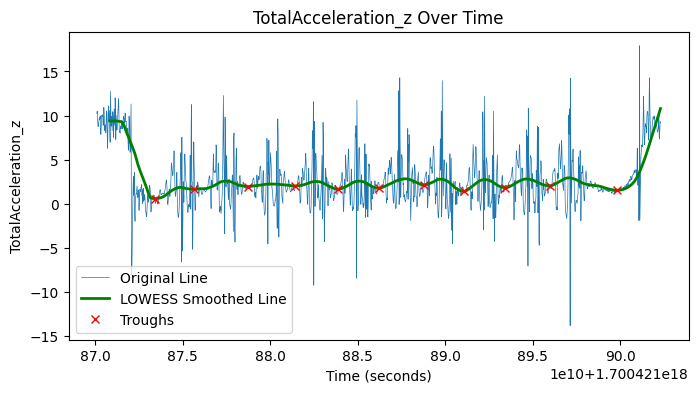

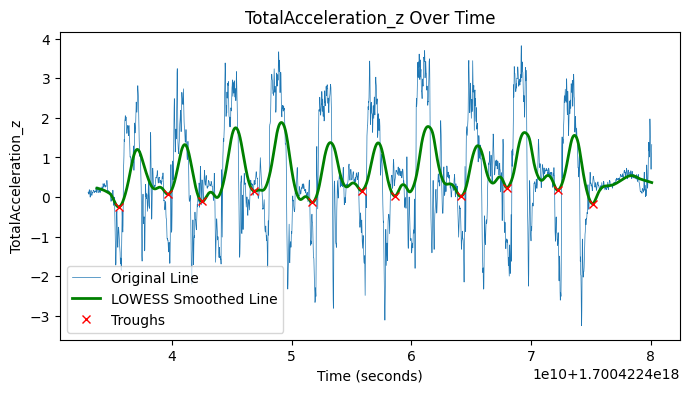

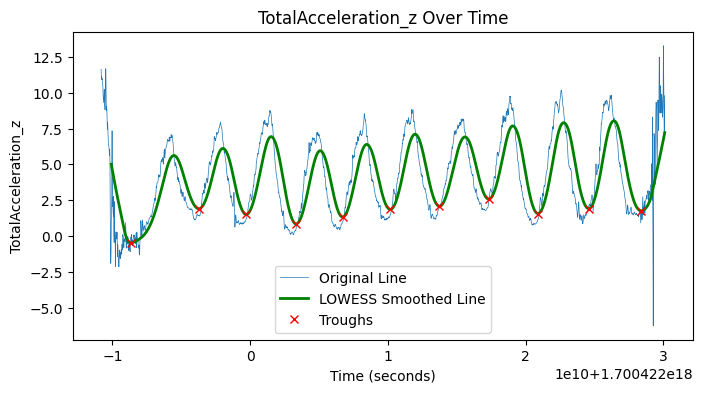

In [92]:
# Initializing an empty list to store indices of troughs in the data
Troughs=[]
for df in [df1,df2,df3,df4,df5,df6]:
  df['moving_avg_z'] = df['z'].rolling(window=40).mean()
  # Applying LOWESS smoothing to find troughs
  lowess_results = lowess(df['moving_avg_z'], df['time'], frac=0.05)
  df_lowess = pd.DataFrame(lowess_results, columns=['time', 'z_lowess'])

  # Finding troughs in the smoothed data to segment the activities
  troughs, _ = find_peaks(-df_lowess['z_lowess'], distance=100)
  Troughs.append(troughs)

  plt.figure(figsize=(8, 4))
  # Plotting the original data
  plt.plot(df['time'], df['z'], label='Original Line', linewidth=0.5)
  # Plotting the smoothed data
  plt.plot(df_lowess['time'], df_lowess['z_lowess'], label='LOWESS Smoothed Line', color='green', linewidth=2)
  # Plotting the identified troughs on the smoothed data
  plt.plot(df_lowess['time'][troughs], df_lowess['z_lowess'][troughs], 'x', label='Troughs', color='red')
  plt.title('TotalAcceleration_z Over Time')
  plt.xlabel('Time (seconds)')
  plt.ylabel('TotalAcceleration_z')
  plt.legend()
  plt.show()

In [93]:
Troughs

[array([  88,  279,  422,  568,  705,  836,  955, 1079, 1200, 1327, 1540]),
 array([ 223,  451,  644,  858, 1055, 1261, 1420, 1616, 1825, 2090, 2237]),
 array([ 106,  322,  511,  705,  907, 1106, 1321, 1508, 1691, 1887, 2093]),
 array([ 136,  253,  415,  558,  686,  809,  945, 1065, 1191, 1324, 1528]),
 array([  96,  313,  464,  694,  949, 1166, 1313, 1603, 1807, 2030, 2184]),
 array([  75,  335,  516,  707,  885, 1068, 1256, 1444, 1633, 1827, 2028])]

In [94]:
# Creating labels for activity type and activity id
df_list=[df1,df2,df3]
for i, name in enumerate(['Jumping_Jack','Lunges','Squat']):
  troughs = Troughs[i]
  df = df_list[i]
  df['activity_type'] = name
  df['activity_id'] = None
  for j in range(len(troughs)-1):
    start = troughs[j]
    end = troughs[j+1]
    df.loc[start:end, 'activity_id'] = j

df_list=[df4,df5,df6]
for i, name in enumerate(['Jumping_Jack','Lunges','Squat']):
  troughs = Troughs[i]
  df = df_list[i]
  df['activity_type'] = name
  df['activity_id'] = None
  for j in range(len(troughs)-1):
    start = troughs[j]
    end = troughs[j+1]
    df.loc[start:end, 'activity_id'] = j+10

In [95]:
# Concatenate all dataframes
df = pd.concat([df1, df2, df3, df4, df5, df6]).dropna(subset=['activity_id'])
# Function to interpolate the data to uniform time steps
def interpolate_group(group, n, time_name='seconds_elapsed', value_name='z', group_name='activity_id'):
    new_time_points = np.linspace(group[time_name].min(), group[time_name].max(), n)
    interp_values = np.interp(new_time_points, group[time_name], group[value_name])
    return pd.DataFrame({
        time_name: new_time_points,
        value_name: interp_values,
        group_name: group[group_name].iloc[0],
        "activity_type": group["activity_type"].iloc[0]
    })

# Interpolate to make each activity group have the same number of time steps
sample_nums = 60
df_interp = df.groupby(['activity_type', 'activity_id']).apply(interpolate_group, n=sample_nums).reset_index(drop=True)

In [96]:
# Aggregate the data by activity type and id, and convert z-axis values to lists
df_agg = df_interp.groupby(['activity_type', 'activity_id']).agg(z=('z', list)).reset_index()
df_agg

,activity_type,activity_id,z
0,Jumping_Jack,0,"[0.0257228426635265, 0.251403014534316, 0.6023..."
1,Jumping_Jack,1,"[0.791725218296051, 0.9999566734722105, 0.7470..."
2,Jumping_Jack,2,"[1.8954145908355715, 0.3815652668110445, -2.01..."
3,Jumping_Jack,3,"[3.497110366821289, 2.0215047421888137, -0.834..."
4,Jumping_Jack,4,"[2.017448663711548, -1.8952682696140668, -0.05..."
5,Jumping_Jack,5,"[-1.2098709344863892, 0.7438688016197726, 2.11..."
6,Jumping_Jack,6,"[-2.179263114929199, -1.6906354010412474, -3.3..."
7,Jumping_Jack,7,"[-1.7820546627044678, -2.4906584439877086, 2.1..."
8,Jumping_Jack,8,"[-4.506283283233643, -1.7093957621977034, 1.75..."
9,Jumping_Jack,9,"[3.873082637786865, -4.497677983635791, 1.9287..."


In [97]:
# Extract features (X) and labels (y)
X = df_agg[['z']]
y = df_agg.activity_type.map({'Jumping_Jack': 0, 'Lunges': 1, 'Squat': 2})

# Split the dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
trainX

,z
44,"[0.5787639617919922, -0.23888144292700625, -0...."
56,"[3.875475406646729, 4.352019018641976, 4.73994..."
8,"[-4.506283283233643, -1.7093957621977034, 1.75..."
59,"[2.822035312652588, 3.8519252088853615, 5.0290..."
55,"[1.464407444000244, 1.6681882308094753, 2.0232..."
15,"[2.2331018447875977, 2.4723838015557917, 1.201..."
22,"[1.1150553226470947, 0.9306305156126102, 1.062..."
2,"[1.8954145908355715, 0.3815652668110445, -2.01..."
13,"[1.9432710409164429, 1.3036827335836343, 1.490..."
41,"[-1.1497513055801392, -0.9168766207805922, -1...."


In [98]:
# Convert the training and testing data into Tensor format
trainX = torch.tensor(np.array(trainX.values.tolist())).float()
trainY = torch.tensor(trainY.tolist())
testX = torch.tensor(np.array(testX.values.tolist())).float()
testY = torch.tensor(testY.tolist())
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

torch.Size([48, 1, 60]) torch.Size([48]) torch.Size([12, 1, 60]) torch.Size([12])


In [99]:
# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# CNN

In [100]:
# CNN model definition
class CNN(nn.Module):
    def __init__(self, num_conv_layers, kernel_sizes, num_filters, pool_sizes):
        super(CNN, self).__init__()
        # Creating convolutional layers based on hyperparameters
        self.convs = nn.ModuleList()
        in_channels = 1
        for i in range(num_conv_layers):
            self.convs.append(nn.Conv1d(in_channels, num_filters[i], kernel_sizes[i], padding=1))
            in_channels = num_filters[i]

        # Creating pooling layers based on hyperparameters
        self.pools = nn.ModuleList([nn.MaxPool1d(size, size) for size in pool_sizes])

        # Calculate the size of the flattened features for the fully connected layer
        self.flattened_size = self.calculate_flattened_size(60, kernel_sizes, pool_sizes, num_filters)

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 3)

    def calculate_flattened_size(self, initial_length, kernel_sizes, pool_sizes, num_filters):
        current_size = initial_length
        for i in range(len(kernel_sizes)):
            current_size = current_size - kernel_sizes[i] + 1 + 2  # Assuming stride=Activity Prediction Model ML and DL Models
            current_size = current_size // pool_sizes[i]
        return current_size * num_filters[-1]

    def forward(self, x):
        for i, (conv, pool) in enumerate(zip(self.convs, self.pools)):
            x = pool(torch.relu(conv(x)))
        x = x.view(-1, self.flattened_size)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

 10%|█         | 10/100 [00:00<00:00, 96.93it/s]

Epoch 5/100, Loss: 0.3261
Epoch 10/100, Loss: 0.0640
Epoch 15/100, Loss: 0.0175


 20%|██        | 20/100 [00:00<00:00, 91.78it/s]

Epoch 20/100, Loss: 0.0009
Epoch 25/100, Loss: 0.0001


 30%|███       | 30/100 [00:00<00:00, 78.60it/s]

Epoch 30/100, Loss: 0.0000
Epoch 35/100, Loss: 0.0000


 39%|███▉      | 39/100 [00:00<00:01, 60.41it/s]

Epoch 40/100, Loss: 0.0000


 46%|████▌     | 46/100 [00:00<00:00, 57.46it/s]

Epoch 45/100, Loss: 0.0000
Epoch 50/100, Loss: 0.0000


 53%|█████▎    | 53/100 [00:00<00:00, 55.89it/s]

Epoch 55/100, Loss: 0.0000


 65%|██████▌   | 65/100 [00:01<00:00, 55.07it/s]

Epoch 60/100, Loss: 0.0000
Epoch 65/100, Loss: 0.0000


 71%|███████   | 71/100 [00:01<00:00, 55.01it/s]

Epoch 70/100, Loss: 0.0000


 77%|███████▋  | 77/100 [00:01<00:00, 54.48it/s]

Epoch 75/100, Loss: 0.0000
Epoch 80/100, Loss: 0.0000


 89%|████████▉ | 89/100 [00:01<00:00, 49.95it/s]

Epoch 85/100, Loss: 0.0000
Epoch 90/100, Loss: 0.0000


100%|██████████| 100/100 [00:01<00:00, 55.62it/s]

Epoch 95/100, Loss: 0.0000
Epoch 100/100, Loss: 0.0000


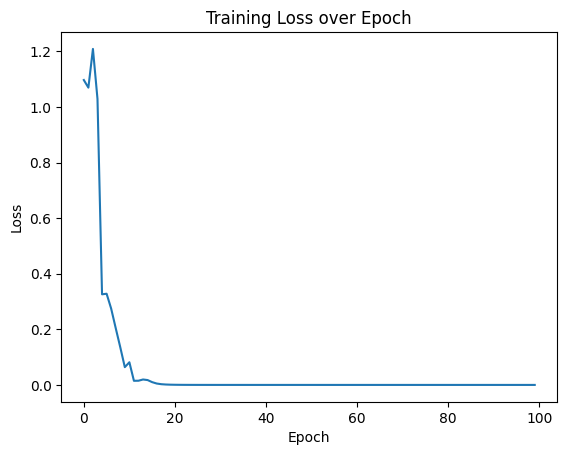

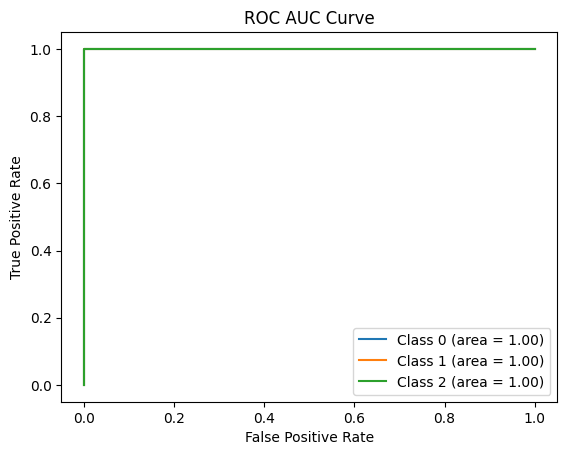

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [101]:
# # Hyperparameters
num_conv_layers = 2  # Number of convolutional layers
kernel_sizes = [3, 3]  # Kernel sizes for each convolutional layer
num_filters = [32, 64]  # Number of filters for each convolutional layer
pool_sizes = [2, 2]  # Pool sizes for each pooling layer
learning_rate = 0.01
num_epochs = 100

# Create an instance of the CNN model with hyperparameters
cnn_net = CNN(num_conv_layers, kernel_sizes, num_filters, pool_sizes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=learning_rate)

losses = []
# Training loop for CNN
for epoch in tqdm(range(num_epochs)):
    outputs = cnn_net(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
plt.plot(losses, label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epoch')
plt.show()

cnn_losses = losses

# Testing the CNN model
cnn_net.eval()
outputs = cnn_net(testX)
predicted_probs = torch.softmax(outputs, dim=1).detach().numpy()
predicted_classes = np.argmax(predicted_probs, axis=1)

for i in range(3):
    fpr, tpr, _ = roc_curve(testY == i, predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='best')
plt.show()

report = classification_report(testY, predicted_classes)
print(report)

  5%|▌         | 5/100 [00:00<00:02, 42.23it/s]

Epoch 5/100, Loss: 0.9273


 10%|█         | 10/100 [00:00<00:02, 43.11it/s]

Epoch 10/100, Loss: 0.1687


 15%|█▌        | 15/100 [00:00<00:01, 43.07it/s]

Epoch 15/100, Loss: 0.0151


 20%|██        | 20/100 [00:00<00:01, 43.92it/s]

Epoch 20/100, Loss: 0.0003


 25%|██▌       | 25/100 [00:00<00:01, 42.15it/s]

Epoch 25/100, Loss: 0.0000


 30%|███       | 30/100 [00:00<00:01, 37.47it/s]

Epoch 30/100, Loss: 0.0001


 34%|███▍      | 34/100 [00:00<00:01, 34.60it/s]

Epoch 35/100, Loss: 0.0000


 45%|████▌     | 45/100 [00:01<00:01, 28.64it/s]

Epoch 40/100, Loss: 0.0000
Epoch 45/100, Loss: 0.0000


 53%|█████▎    | 53/100 [00:01<00:01, 30.01it/s]

Epoch 50/100, Loss: 0.0000
Epoch 55/100, Loss: 0.0000


 67%|██████▋   | 67/100 [00:01<00:00, 37.51it/s]

Epoch 60/100, Loss: 0.0000
Epoch 65/100, Loss: 0.0000


 77%|███████▋  | 77/100 [00:02<00:00, 39.96it/s]

Epoch 70/100, Loss: 0.0000
Epoch 75/100, Loss: 0.0000


 87%|████████▋ | 87/100 [00:02<00:00, 40.80it/s]

Epoch 80/100, Loss: 0.0000
Epoch 85/100, Loss: 0.0000


 97%|█████████▋| 97/100 [00:02<00:00, 40.21it/s]

Epoch 90/100, Loss: 0.0000
Epoch 95/100, Loss: 0.0000


100%|██████████| 100/100 [00:02<00:00, 36.71it/s]


Epoch 100/100, Loss: 0.0000


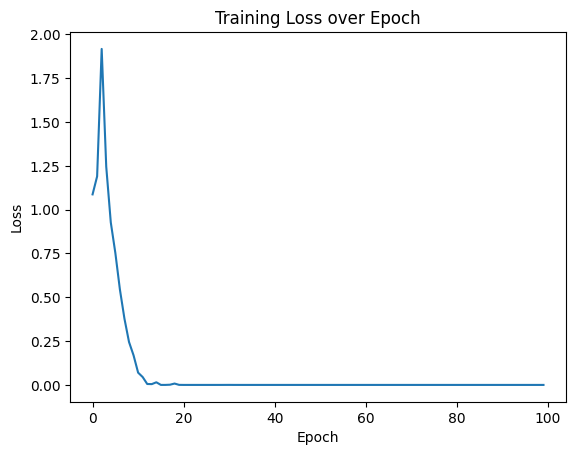

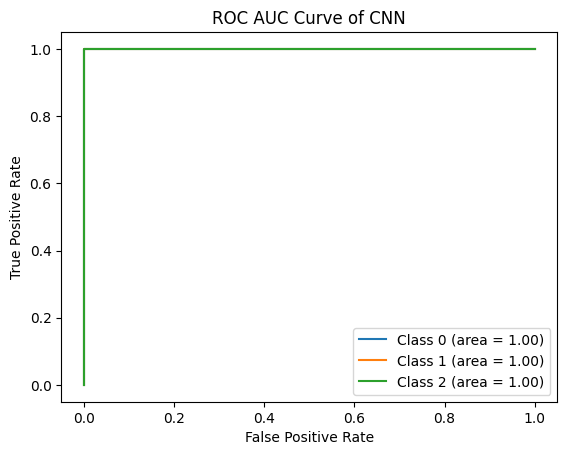

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [102]:
# different hyperparameters
num_conv_layers = 3
kernel_sizes = [3, 5, 3]
num_filters = [32, 64, 128]
pool_sizes = [2, 2, 2]
learning_rate = 0.01
num_epochs = 100

cnn_net = CNN(num_conv_layers, kernel_sizes, num_filters, pool_sizes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_net.parameters(), lr=learning_rate)

losses = []
for epoch in tqdm(range(num_epochs)):
    outputs = cnn_net(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epoch')
plt.show()

# Testing the CNN model
cnn_net.eval()
outputs = cnn_net(testX)
predicted_probs = torch.softmax(outputs, dim=1).detach().numpy()
predicted_classes = np.argmax(predicted_probs, axis=1)

for i in range(3):
    fpr, tpr, _ = roc_curve(testY == i, predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve of CNN')
plt.legend(loc='best')
plt.show()

report = classification_report(testY, predicted_classes)
print(report)

# GRU

In [103]:
# GRU Model Definition
class SimpleGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super(SimpleGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.gru(x)
        x = self.linear(x[:,-1,:])
        return x

  4%|▍         | 4/100 [00:00<00:03, 31.86it/s]

Epoch 5/100, Loss: 1.1140


  8%|▊         | 8/100 [00:00<00:02, 30.82it/s]

Epoch 10/100, Loss: 1.0793


 12%|█▏        | 12/100 [00:00<00:02, 29.34it/s]

Epoch 15/100, Loss: 1.0557


 19%|█▉        | 19/100 [00:00<00:02, 29.20it/s]

Epoch 20/100, Loss: 1.0361


 23%|██▎       | 23/100 [00:00<00:02, 30.06it/s]

Epoch 25/100, Loss: 1.0175


 27%|██▋       | 27/100 [00:00<00:02, 30.20it/s]

Epoch 30/100, Loss: 0.9999


 35%|███▌      | 35/100 [00:01<00:02, 29.97it/s]

Epoch 35/100, Loss: 0.9838


 39%|███▉      | 39/100 [00:01<00:02, 30.39it/s]

Epoch 40/100, Loss: 0.9684


 43%|████▎     | 43/100 [00:01<00:01, 30.65it/s]

Epoch 45/100, Loss: 0.9522


 47%|████▋     | 47/100 [00:01<00:01, 30.80it/s]

Epoch 50/100, Loss: 0.9324


 54%|█████▍    | 54/100 [00:01<00:01, 29.09it/s]

Epoch 55/100, Loss: 0.9049


 58%|█████▊    | 58/100 [00:01<00:01, 29.80it/s]

Epoch 60/100, Loss: 0.8650


 66%|██████▌   | 66/100 [00:02<00:01, 30.38it/s]

Epoch 65/100, Loss: 0.8145


 70%|███████   | 70/100 [00:02<00:00, 31.07it/s]

Epoch 70/100, Loss: 0.7565


 74%|███████▍  | 74/100 [00:02<00:00, 31.21it/s]

Epoch 75/100, Loss: 0.6984


 78%|███████▊  | 78/100 [00:02<00:00, 30.38it/s]

Epoch 80/100, Loss: 0.6216


 82%|████████▏ | 82/100 [00:02<00:00, 30.19it/s]

Epoch 85/100, Loss: 0.5548


 90%|█████████ | 90/100 [00:02<00:00, 29.62it/s]

Epoch 90/100, Loss: 0.5150


 93%|█████████▎| 93/100 [00:03<00:00, 29.47it/s]

Epoch 95/100, Loss: 0.4952


100%|██████████| 100/100 [00:03<00:00, 30.27it/s]

Epoch 100/100, Loss: 0.4805


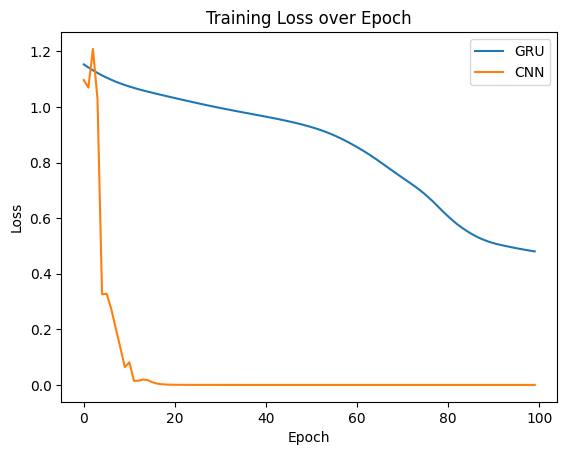

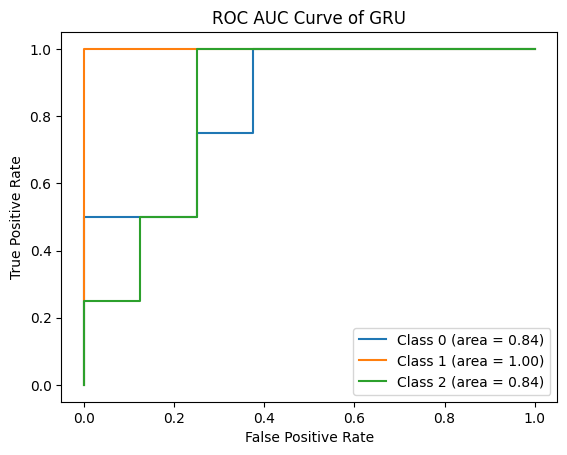

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       1.00      1.00      1.00         4
           2       0.60      0.75      0.67         4

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12



In [104]:
# Hyperparameters
input_size = 1
hidden_size = 2
num_layers = 1
learning_rate = 0.01
num_epochs = 100
num_classes = 3

gru_model = SimpleGRU(input_size, hidden_size,num_classes, num_layers)
criterion = nn.CrossEntropyLoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

losses = []
# Train GRU
for epoch in tqdm(range(num_epochs)):
    outputs = gru_model(trainX.transpose(1, 2))
    gru_optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    gru_optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
plt.plot(losses, label='GRU')
plt.plot(cnn_losses, label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epoch')
#plt.show()

plt.legend()
plt.show()

# Test the GRU Model
gru_model.eval()
outputs = gru_model(testX.transpose(1, 2))
predicted_probs = torch.softmax(outputs, dim=1).detach().numpy()
predicted_classes = np.argmax(predicted_probs, axis=1)

for i in range(3):
    fpr, tpr, _ = roc_curve(testY == i, predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve of GRU')
plt.legend(loc='best')
plt.show()

report = classification_report(testY, predicted_classes)
print(report)

  6%|▌         | 6/100 [00:00<00:08, 11.36it/s]

Epoch 5/100, Loss: 1.0816


 12%|█▏        | 12/100 [00:01<00:08, 10.98it/s]

Epoch 10/100, Loss: 0.9656


 16%|█▌        | 16/100 [00:01<00:07, 10.58it/s]

Epoch 15/100, Loss: 0.6880


 22%|██▏       | 22/100 [00:02<00:07, 10.84it/s]

Epoch 20/100, Loss: 0.5100


 26%|██▌       | 26/100 [00:02<00:06, 10.61it/s]

Epoch 25/100, Loss: 0.4275


 32%|███▏      | 32/100 [00:02<00:05, 11.61it/s]

Epoch 30/100, Loss: 0.3371


 36%|███▌      | 36/100 [00:03<00:05, 11.72it/s]

Epoch 35/100, Loss: 0.2497


 42%|████▏     | 42/100 [00:03<00:05, 11.24it/s]

Epoch 40/100, Loss: 0.2155


 46%|████▌     | 46/100 [00:04<00:04, 11.65it/s]

Epoch 45/100, Loss: 0.0922


 52%|█████▏    | 52/100 [00:04<00:04, 11.40it/s]

Epoch 50/100, Loss: 0.0649


 56%|█████▌    | 56/100 [00:04<00:03, 11.06it/s]

Epoch 55/100, Loss: 0.1036


 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

Epoch 60/100, Loss: 0.0375


 66%|██████▌   | 66/100 [00:05<00:03, 10.73it/s]

Epoch 65/100, Loss: 0.0301


 72%|███████▏  | 72/100 [00:06<00:02, 11.11it/s]

Epoch 70/100, Loss: 0.0255


 76%|███████▌  | 76/100 [00:06<00:02, 11.68it/s]

Epoch 75/100, Loss: 0.0218


 82%|████████▏ | 82/100 [00:07<00:01, 11.50it/s]

Epoch 80/100, Loss: 0.0187


 86%|████████▌ | 86/100 [00:07<00:01, 11.94it/s]

Epoch 85/100, Loss: 0.0167


 92%|█████████▏| 92/100 [00:08<00:00, 12.01it/s]

Epoch 90/100, Loss: 0.0149


 96%|█████████▌| 96/100 [00:08<00:00, 11.82it/s]

Epoch 95/100, Loss: 0.0135


100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


Epoch 100/100, Loss: 0.0123


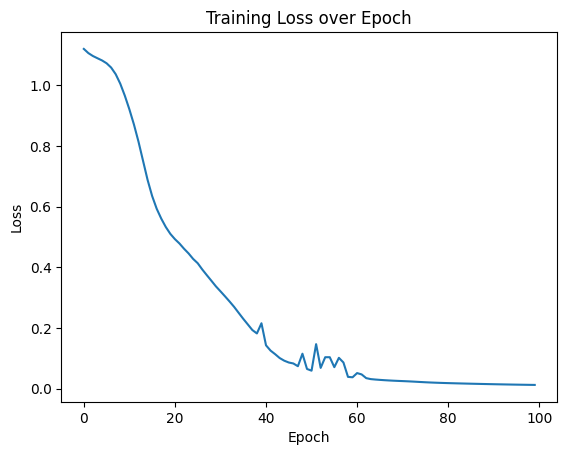

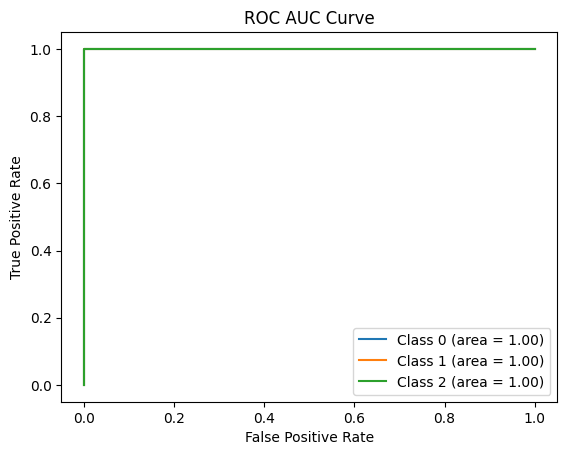

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [105]:
# different hyperparameters
input_size = 1
hidden_size = 8
num_layers = 4
learning_rate = 0.01
num_epochs = 100
num_classes = 3

gru_model = SimpleGRU(input_size, hidden_size,num_classes, num_layers)
criterion = nn.CrossEntropyLoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

losses = []
# Train GRU
for epoch in tqdm(range(num_epochs)):
    outputs = gru_model(trainX.transpose(1, 2))
    gru_optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    gru_optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epoch')
plt.show()

# Test the GRU Model
gru_model.eval()
outputs = gru_model(testX.transpose(1, 2))
predicted_probs = torch.softmax(outputs, dim=1).detach().numpy()
predicted_classes = np.argmax(predicted_probs, axis=1)

for i in range(3):
    fpr, tpr, _ = roc_curve(testY == i, predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='best')
plt.show()

report = classification_report(testY, predicted_classes)
print(report)

# Hybrid Model

In [106]:
class HybridModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super(HybridModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(input_size, 32, 3, padding=1)
        self.conv2 = nn.Conv1d(32, 64, 3, padding=1)
        self.max_pool = nn.MaxPool1d(2, 2)
        self.global_pool = nn.AdaptiveMaxPool1d(1)

        # GRU layers
        self.gru = nn.GRU(64, hidden_size, num_layers, batch_first=True)
        # Output layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = torch.relu(self.conv1(x))
        x = self.max_pool(x)
        x = torch.relu(self.conv2(x))
        x = self.global_pool(x)

        x =x.transpose(1, 2)
        # Apply GRU layers
        x, _ = self.gru(x)

        # Apply the output layer
        x = self.fc(x[:,-1,:])
        return x

Epoch 5/100, Loss: 1.0875
Epoch 10/100, Loss: 1.0254
Epoch 15/100, Loss: 0.8829
Epoch 20/100, Loss: 0.6950
Epoch 25/100, Loss: 0.5353
Epoch 30/100, Loss: 0.3881
Epoch 35/100, Loss: 0.2466
Epoch 40/100, Loss: 0.1401
Epoch 45/100, Loss: 0.0804
Epoch 50/100, Loss: 0.0502
Epoch 55/100, Loss: 0.0342
Epoch 60/100, Loss: 0.0251
Epoch 65/100, Loss: 0.0195
Epoch 70/100, Loss: 0.0158
Epoch 75/100, Loss: 0.0134
Epoch 80/100, Loss: 0.0116
Epoch 85/100, Loss: 0.0104
Epoch 90/100, Loss: 0.0094
Epoch 95/100, Loss: 0.0086
Epoch 100/100, Loss: 0.0079


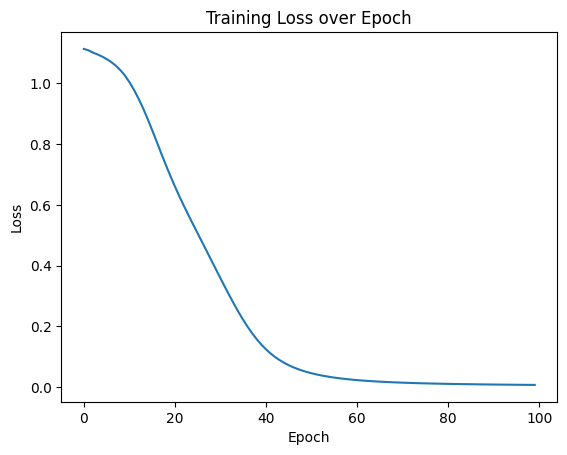

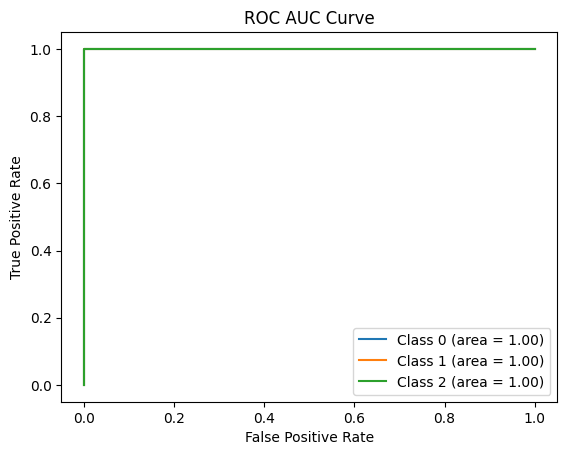

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         4

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



In [107]:
# Hyperparameters
input_size = 1
hidden_size = 8
num_layers = 4
learning_rate = 0.01
num_epochs = 100
num_classes = 3

hybrid_model = HybridModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes, num_layers=num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=learning_rate)

losses = []
for epoch in (range(num_epochs)):
    outputs = hybrid_model(trainX)
    optimizer.zero_grad()
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epoch')
plt.show()

# Test the Hybrid Model
hybrid_model.eval()
outputs = hybrid_model(testX)
predicted_probs = torch.softmax(outputs, dim=1).detach().numpy()
predicted_classes = np.argmax(predicted_probs, axis=1)

for i in range(3):
    fpr, tpr, _ = roc_curve(testY == i, predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='best')
plt.show()

report = classification_report(testY, predicted_classes)
print(report)